In [ ]:
import os
import warnings
import numpy as np
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method"

# All outputs go here
OUTPUT_DIR = os.path.join(BASE_DIR, "Output_SingleTrend")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Input stays in BASE_DIR
FILENAME = "0_data_input_monthly.csv"
PATH = os.path.join(BASE_DIR, FILENAME)

# Outputs (NO calibration outputs)
OUT_BACKTEST_DETAIL   = os.path.join(OUTPUT_DIR, "backtest_detail.csv")
OUT_BACKTEST_SUMMARY  = os.path.join(OUTPUT_DIR, "backtest_summary.csv")

# Month-level backtest rows so Part 2 (or PowerBI) can compute FY-YTD WAPE/Bias
OUT_BACKTEST_MONTHLY  = os.path.join(OUTPUT_DIR, "backtest_monthly_org.csv")

# Forecasts (ORG only)
OUT_FORECAST_ALL_ORG  = os.path.join(OUTPUT_DIR, "forecast_all_models_18m_org.csv")
OUT_FY_TOTALS_ORG     = os.path.join(OUTPUT_DIR, "forecast_fy_totals_org.csv")

print("Outputs will be saved to:", OUTPUT_DIR)

DATE_COL = "ACC_MONTH"
Y_COL = "TOT_PAID"
EXOG_COLS = ["BUDGET_AMT", "NBR_MURDER"]

H = 18  # months forecast horizon
POST_START = pd.Timestamp("2021-04-01")

# FY2020-21 outlier period (inclusive month starts)
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

MIN_CUTOFF = POST_START
LAG_MIN, LAG_MAX = 0, 12

# Rolling training window length
TRAIN_WINDOW_MONTHS = 60
MIN_TRAIN_MONTHS = 36  # safety minimum

# Seasonal Moving Average parameters
SEASONAL_MA_YEARS = 3

# Governance thresholds (Part 2 can use these, but Part 1 doesn't select winner)
THRESH_WAPE_OK = 10.0
THRESH_WAPE_WATCH = 15.0
THRESH_BIAS_OK = 3.0
THRESH_BIAS_WATCH = 5.0


# -----------------------------
# Optional dependencies
# -----------------------------
PROPHET_AVAILABLE = False
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

STATSMODELS_AVAILABLE = False
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    STATSMODELS_AVAILABLE = True
except Exception:
    STATSMODELS_AVAILABLE = False


# -----------------------------
# Safe CSV writer
# -----------------------------
def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    try:
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback


# -----------------------------
# Metrics
# -----------------------------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    yt = y_true[m]
    yp = y_pred[m]
    denom = (np.abs(yt) + np.abs(yp))
    denom[denom == 0] = np.nan
    return np.nanmean(200.0 * np.abs(yp - yt) / denom)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return np.sqrt(np.nanmean((y_pred[m] - y_true[m]) ** 2))

def mase(y_true, y_pred, y_train, m=12):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    mt = np.isfinite(y_true) & np.isfinite(y_pred)
    if mt.sum() == 0:
        return np.nan

    y_train = y_train[np.isfinite(y_train)]
    if len(y_train) <= m:
        return np.nan
    denom = np.nanmean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return np.nanmean(np.abs(y_true[mt] - y_pred[mt])) / denom

def wape(y_true, y_pred):
    """WAPE (%): 100 * sum(|pred-actual|) / sum(|actual|)"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(np.abs(y_pred[m] - y_true[m])) / denom))

def mean_error(y_true, y_pred):
    """Mean Error (ME): average(pred - actual) in $ units."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return float(np.nanmean(y_pred[m] - y_true[m]))

def bias_wape(y_true, y_pred):
    """Bias% (WAPE-style): 100 * sum(pred-actual) / sum(|actual|)"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(y_pred[m] - y_true[m]) / denom))


# -----------------------------
# Fiscal helpers
# -----------------------------
def fy_start_year(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 4 else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(dt)
    return f"FY{y}-{str(y+1)[-2:]}"

def fy_start_date_for(dt: pd.Timestamp) -> pd.Timestamp:
    """FY starts April 1."""
    y = fy_start_year(dt)
    return pd.Timestamp(year=y, month=4, day=1)


# -----------------------------
# Read & prepare data
# -----------------------------
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

required = [DATE_COL, Y_COL] + EXOG_COLS
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()

df[DATE_COL] = df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")
df = df.sort_values(DATE_COL).reset_index(drop=True)

for c in [Y_COL] + EXOG_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.set_index(DATE_COL).sort_index()
df = df.asfreq("MS")
df["POST"] = (df.index >= POST_START).astype(int)


# -----------------------------
# Outlier handling
# -----------------------------
def fill_outlier_with_past_ma(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp, window_months: int = 24) -> pd.Series:
    s = s.astype(float).copy()
    outlier_idx = s.loc[start:end].index
    for d in outlier_idx:
        hist_end = d - pd.DateOffset(months=1)
        hist_start = d - pd.DateOffset(months=window_months)
        hist = s.loc[hist_start:hist_end].dropna()
        if len(hist) == 0:
            hist2 = s.loc[:hist_end].dropna()
            fill_val = float(hist2.mean()) if len(hist2) else np.nan
        else:
            fill_val = float(hist.tail(window_months).mean())
        s.loc[d] = fill_val
    return s

for c in [Y_COL] + EXOG_COLS:
    df[c] = fill_outlier_with_past_ma(df[c], OUTLIER_START, OUTLIER_END, window_months=24)

df = df.dropna(subset=[Y_COL])


# -----------------------------
# Lag selection (TRAIN only)
# -----------------------------
def pick_best_lag(train_df, y=Y_COL, x="BUDGET_AMT", lag_min=0, lag_max=12):
    best_lag = 0
    best_abs = -np.inf
    yv = train_df[y].astype(float)
    xv = pd.to_numeric(train_df[x], errors="coerce")
    for lag in range(lag_min, lag_max + 1):
        xlag = xv.shift(lag)
        corr = pd.concat([yv, xlag], axis=1).corr().iloc[0, 1]
        if np.isfinite(corr) and abs(corr) > best_abs:
            best_abs = abs(corr)
            best_lag = lag
    return best_lag

def make_exog_features(base_df, lag_budget, lag_murder, post_start=POST_START):
    out = pd.DataFrame(index=base_df.index)
    out["BUDGET_L"] = pd.to_numeric(base_df["BUDGET_AMT"], errors="coerce").shift(lag_budget)
    out["MURDER_L"] = pd.to_numeric(base_df["NBR_MURDER"], errors="coerce").shift(lag_murder)
    out["POST"] = (out.index >= post_start).astype(int)
    out["POST_x_BUDGET_L"] = out["POST"] * out["BUDGET_L"]
    out["POST_x_MURDER_L"] = out["POST"] * out["MURDER_L"]
    return out


# -----------------------------
# Baseline Models
# -----------------------------
def fit_predict_seasonal_naive_recursive(train_y: pd.Series, future_index: pd.DatetimeIndex, season=12):
    hist = train_y.astype(float).copy().asfreq("MS")
    preds = []
    for d in future_index:
        ref = d - pd.DateOffset(months=season)
        val = hist.get(ref, np.nan)
        if not np.isfinite(val):
            last = hist.dropna().iloc[-1] if hist.dropna().shape[0] else 0.0
            val = last
        preds.append(float(val))
        hist.loc[d] = float(val)
    return pd.Series(preds, index=future_index, dtype=float)

def fit_predict_seasonal_moving_average(train_y: pd.Series, future_index: pd.DatetimeIndex, years=3):
    y = train_y.astype(float).asfreq("MS").dropna()
    if y.empty:
        return pd.Series(0.0, index=future_index, dtype=float)
    k = max(1, int(years))
    out = []
    for d in future_index:
        same_month = y[y.index.month == d.month]
        out.append(float(y.mean()) if same_month.empty else float(same_month.tail(k).mean()))
    return pd.Series(out, index=future_index, dtype=float)


# -----------------------------
# ETS (robust)
# -----------------------------
def fit_predict_ets_robust(train_y: pd.Series, test_index: pd.DatetimeIndex):
    if not STATSMODELS_AVAILABLE:
        return pd.Series(np.nan, index=test_index)

    y = train_y.astype(float).asfreq("MS").dropna()
    if len(y) < 24:
        return fit_predict_seasonal_naive_recursive(y, test_index, season=12)

    specs = [
        dict(trend="add", seasonal="add"),
        dict(trend="add", seasonal=None),
        dict(trend=None, seasonal="add"),
    ]
    if (y > 0).all():
        specs.insert(1, dict(trend="add", seasonal="mul"))

    for sp in specs:
        try:
            model = ExponentialSmoothing(
                y,
                trend=sp["trend"],
                seasonal=sp["seasonal"],
                seasonal_periods=12 if sp["seasonal"] is not None else None,
                initialization_method="estimated",
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = model.fit(optimized=True)

            fc = res.forecast(len(test_index))
            fc = pd.Series(fc.values, index=test_index, dtype=float)
            if np.isfinite(fc.values).all():
                return fc
        except Exception:
            continue

    return fit_predict_seasonal_naive_recursive(y, test_index, season=12)


# -----------------------------
# Prophet helpers
# -----------------------------
def prophet_univar_forecast(train_series: pd.Series, future_index: pd.DatetimeIndex):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    s = train_series.astype(float).dropna()
    if len(s) < 12:
        return fit_predict_seasonal_naive_recursive(s, future_index, season=12)

    train_df = s.reset_index()
    train_df.columns = ["ds", "y"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    m.fit(train_df)

    fut = pd.DataFrame({"ds": future_index})
    pred = m.predict(fut)["yhat"].values
    return pd.Series(pred, index=future_index, dtype=float)

def prophet_univar_totpaid(train_y: pd.Series, test_index: pd.DatetimeIndex):
    return prophet_univar_forecast(train_y, test_index)

def _ensure_future_regressor(train_series: pd.Series, future_index: pd.DatetimeIndex):
    s = train_series.astype(float).asfreq("MS")
    fc = pd.Series(np.nan, index=future_index, dtype=float)

    if PROPHET_AVAILABLE:
        try:
            fc = prophet_univar_forecast(s, future_index)
        except Exception:
            fc = pd.Series(np.nan, index=future_index, dtype=float)

    if not np.isfinite(fc.values).all():
        sn = fit_predict_seasonal_naive_recursive(s.dropna(), future_index, season=12)
        fc = fc.where(np.isfinite(fc), sn)

    if not np.isfinite(fc.values).all():
        last = s.dropna().iloc[-1] if s.dropna().shape[0] else 0.0
        fc = fc.fillna(last)

    return fc.astype(float)

def prophet_regressors_with_reg_forecasts(train_df, test_index, lag_budget, lag_murder):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    train_df = train_df.copy().asfreq("MS")

    bud_future = _ensure_future_regressor(train_df["BUDGET_AMT"], test_index)
    mur_future = _ensure_future_regressor(train_df["NBR_MURDER"], test_index)

    full_index = pd.date_range(train_df.index.min(), test_index.max(), freq="MS")
    base = pd.DataFrame(index=full_index)

    base["BUDGET_AMT"] = train_df["BUDGET_AMT"].reindex(full_index)
    base["NBR_MURDER"] = train_df["NBR_MURDER"].reindex(full_index)

    base.loc[test_index, "BUDGET_AMT"] = bud_future.values
    base.loc[test_index, "NBR_MURDER"] = mur_future.values

    base["BUDGET_AMT"] = base["BUDGET_AMT"].interpolate(limit_direction="both")
    base["NBR_MURDER"] = base["NBR_MURDER"].interpolate(limit_direction="both")

    exog_all = make_exog_features(base, lag_budget, lag_murder).ffill().bfill()

    y_series = train_df[Y_COL].astype(float).rename("y")
    y_series.index.name = "ds"

    exog_train = exog_all.loc[train_df.index].copy()
    exog_train.index.name = "ds"

    p_train = pd.concat([y_series, exog_train], axis=1).dropna().reset_index()
    if p_train.shape[0] < 24:
        return prophet_univar_totpaid(train_df[Y_COL], test_index)

    reg_cols = ["BUDGET_L", "MURDER_L", "POST", "POST_x_BUDGET_L", "POST_x_MURDER_L"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    for r in reg_cols:
        m.add_regressor(r, prior_scale=0.2)

    m.fit(p_train[["ds", "y"] + reg_cols])

    exog_future = exog_all.loc[test_index].copy()
    exog_future.index.name = "ds"
    p_future = exog_future.reset_index()

    pred = m.predict(p_future)[["ds", "yhat"]].set_index("ds")["yhat"].astype(float)
    return pred.reindex(test_index)


# -----------------------------
# Build rolling-origin cutoffs (POST only, horizon H)
# -----------------------------
all_months = df.index.dropna()
last_date = all_months.max()

cutoffs = []
for d in all_months:
    if d < MIN_CUTOFF:
        continue
    if d + pd.DateOffset(months=H) <= last_date:
        cutoffs.append(d)

if len(cutoffs) == 0:
    raise ValueError("No valid cutoffs for post-break CV. Check date range and H.")


# -----------------------------
# Backtest loop (ORG only + monthly rows)
# -----------------------------
detail_rows = []
monthly_rows = []

def _record_one(cutoff, train_start, train_end, test_start, test_end,
                model, lag_budget, lag_murder, y_train, y_test, pred, err=None):
    ok = bool(np.isfinite(np.asarray(pred, dtype=float)).all()) and (len(pred) == len(y_test))
    return {
        "cutoff": cutoff,
        "train_start": train_start,
        "train_end": train_end,
        "test_start": test_start,
        "test_end": test_end,
        "model": model,
        "lag_budget": lag_budget,
        "lag_murder": lag_murder,
        "sMAPE": smape(y_test.values, pred.values),
        "WAPE_pct": wape(y_test.values, pred.values),
        "RMSE": rmse(y_test.values, pred.values),
        "MASE": mase(y_test.values, pred.values, y_train.values, m=12),
        "ME": mean_error(y_test.values, pred.values),
        "Bias_WAPE_pct": bias_wape(y_test.values, pred.values),
        "ok": ok,
        "error": "" if err is None else str(err)[:500],
    }

def _record_monthly(cutoff, model, y_test: pd.Series, pred: pd.Series):
    dfm = pd.DataFrame({
        "cutoff": pd.Timestamp(cutoff),
        "ds": y_test.index,
        "model": model,
        "y_actual": pd.to_numeric(y_test.values, errors="coerce"),
        "yhat": pd.to_numeric(pred.values, errors="coerce"),
    })
    dfm["error"] = dfm["yhat"] - dfm["y_actual"]
    dfm["abs_error"] = np.abs(dfm["error"])
    dfm["FY"] = dfm["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
    monthly_rows.extend(dfm.to_dict("records"))

def _run_and_record(cutoff, train_start, train_end, test_index, model, lag_budget, lag_murder, y_train, y_test, pred, err=None):
    detail_rows.append(_record_one(
        cutoff, train_start, train_end, test_index.min(), test_index.max(),
        model, lag_budget, lag_murder, y_train, y_test, pred, err
    ))
    _record_monthly(cutoff, model, y_test, pred)

for cutoff in cutoffs:
    train_full = df.loc[:cutoff].copy()
    train = train_full.tail(TRAIN_WINDOW_MONTHS).copy()

    test_start = cutoff + pd.DateOffset(months=1)
    test_end = cutoff + pd.DateOffset(months=H)
    test = df.loc[test_start:test_end].copy()

    if test.shape[0] < H:
        continue

    y_train = train[Y_COL].astype(float)
    y_test = test[Y_COL].astype(float)
    test_index = test.index

    if y_train.dropna().shape[0] < MIN_TRAIN_MONTHS:
        continue

    lag_budget = pick_best_lag(train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
    lag_murder = pick_best_lag(train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

    train_start = train.index.min()
    train_end = train.index.max()

    # M0a
    try:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        pred = pd.Series(np.nan, index=test_index, dtype=float)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test, pred, e)

    # M0b
    try:
        pred = fit_predict_seasonal_moving_average(y_train, test_index, years=SEASONAL_MA_YEARS)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        pred = pd.Series(np.nan, index=test_index, dtype=float)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test, pred, e)

    # M1
    try:
        pred = fit_predict_ets_robust(y_train, test_index)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred, e)

    if PROPHET_AVAILABLE:
        # M2
        try:
            pred = prophet_univar_totpaid(y_train, test_index)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test, pred)
        except Exception as e:
            pred = pd.Series(np.nan, index=test_index, dtype=float)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test, pred, e)

        # M3
        try:
            train_df_m3 = train[[Y_COL] + EXOG_COLS].copy()
            pred = prophet_regressors_with_reg_forecasts(train_df_m3, test_index, lag_budget, lag_murder)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred)
        except Exception as e:
            pred = prophet_univar_totpaid(y_train, test_index)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred, e)

detail = pd.DataFrame(detail_rows)
saved_detail = safe_to_csv(detail, OUT_BACKTEST_DETAIL, index=False)
print("Saved backtest detail:", saved_detail)

monthly_df = pd.DataFrame(monthly_rows)
monthly_df["cutoff"] = pd.to_datetime(monthly_df["cutoff"], errors="coerce")
monthly_df["ds"] = pd.to_datetime(monthly_df["ds"], errors="coerce")
for c in ["y_actual", "yhat", "error", "abs_error"]:
    monthly_df[c] = pd.to_numeric(monthly_df[c], errors="coerce")
saved_monthly = safe_to_csv(monthly_df, OUT_BACKTEST_MONTHLY, index=False)
print("Saved backtest monthly org:", saved_monthly)


# -----------------------------
# Summary (model)
# -----------------------------
summary = (
    detail.groupby(["model"], as_index=False)
          .agg(
              smape_mean=("sMAPE", "mean"),
              smape_median=("sMAPE", "median"),
              wape_mean=("WAPE_pct", "mean"),
              wape_median=("WAPE_pct", "median"),
              rmse_mean=("RMSE", "mean"),
              mase_mean=("MASE", "mean"),
              me_mean=("ME", "mean"),
              bias_wape_mean=("Bias_WAPE_pct", "mean"),
              n_ok=("ok", "sum"),
              n_total=("ok", "count"),
          )
)
saved_summary = safe_to_csv(summary, OUT_BACKTEST_SUMMARY, index=False)
print("Saved backtest summary:", saved_summary)


# -----------------------------
# Final forecasts: next 18 months for ALL models (ORG only)
# -----------------------------
last_obs = df.index.max()
future_idx = pd.date_range(last_obs + pd.DateOffset(months=1), periods=H, freq="MS")

deploy_train = df.loc[:last_obs].tail(TRAIN_WINDOW_MONTHS).copy()
y_deploy = deploy_train[Y_COL].astype(float)

fc_org = pd.DataFrame({"ds": future_idx})

fc_org["M0_SeasonalNaive_recursive"] = fit_predict_seasonal_naive_recursive(y_deploy, future_idx, season=12).values
fc_org["M0_SeasonalMovingAverage"]   = fit_predict_seasonal_moving_average(y_deploy, future_idx, years=SEASONAL_MA_YEARS).values
fc_org["M1_ETS_univariate"]          = fit_predict_ets_robust(y_deploy, future_idx).values

if PROPHET_AVAILABLE:
    fc_org["M2_Prophet_univariate"] = prophet_univar_totpaid(y_deploy, future_idx).values
else:
    fc_org["M2_Prophet_univariate"] = np.nan

lag_budget_full = pick_best_lag(deploy_train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
lag_murder_full = pick_best_lag(deploy_train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

if PROPHET_AVAILABLE:
    try:
        train_df_full = deploy_train[[Y_COL] + EXOG_COLS].copy()
        fc_org["M3_Prophet_regressors_regForecast"] = prophet_regressors_with_reg_forecasts(
            train_df_full, future_idx, lag_budget_full, lag_murder_full
        ).values
    except Exception:
        fc_org["M3_Prophet_regressors_regForecast"] = fc_org["M2_Prophet_univariate"].values
else:
    fc_org["M3_Prophet_regressors_regForecast"] = np.nan

saved_org = safe_to_csv(fc_org, OUT_FORECAST_ALL_ORG, index=False)
print("Saved ORG all-model 18m forecasts:", saved_org)

# FY totals ORG
fc_org_fy = fc_org.copy()
fc_org_fy["FY"] = fc_org_fy["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
fy_org = fc_org_fy.groupby("FY").sum(numeric_only=True).reset_index()
saved_fy_org = safe_to_csv(fy_org, OUT_FY_TOTALS_ORG, index=False)
print("Saved ORG forecast FY totals:", saved_fy_org)


print("\nDone. Part 1 outputs now include:")
print(" - backtest_detail.csv (18m window metrics per cutoff/model)")
print(" - backtest_monthly_org.csv (month-level forecast vs actual; Part 2 can compute FY-YTD WAPE/Bias)")
print(" - backtest_summary.csv (overall model summary)")
print(" - forecast_all_models_18m_org.csv + forecast_fy_totals_org.csv")


Outputs will be saved to: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_0


c:\GitHub\.Laptopvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


FileNotFoundError: [Errno 2] No such file or directory: '\\\\Sherwood\\accounting\\Share\\Finance Meetings & Reports\\Monthly Reports\\BCM Report Monthly\\Power BI Report\\Forecasting Method\\data_input_monthly.csv'

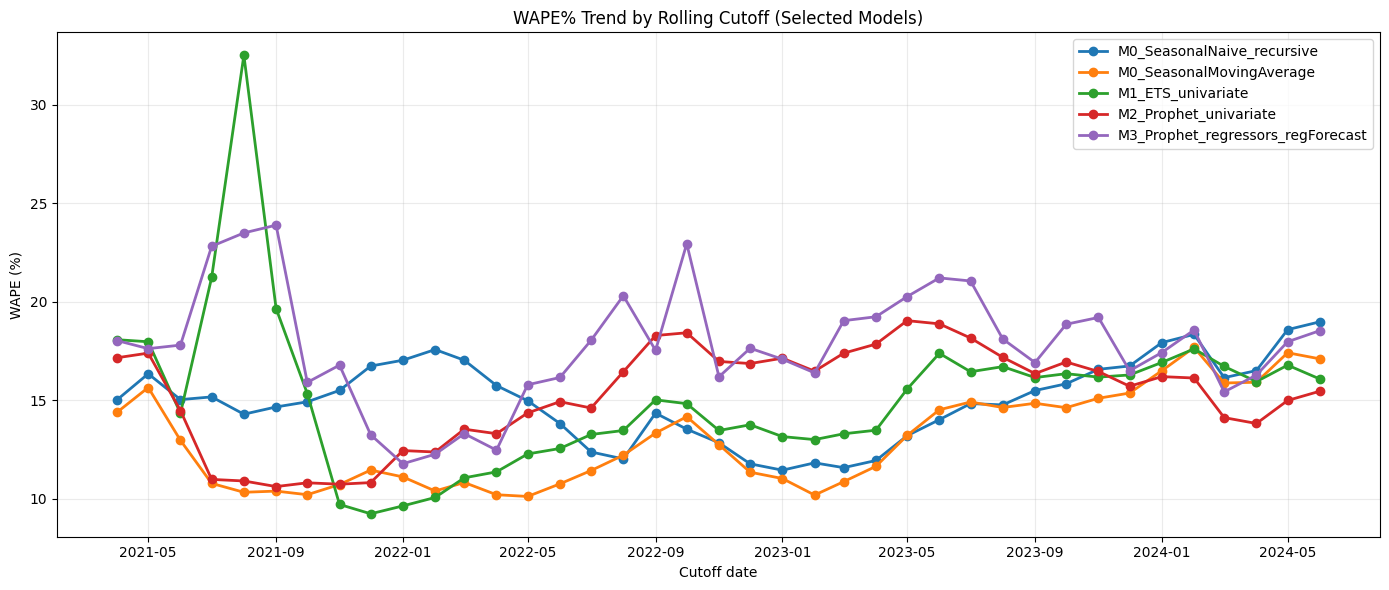

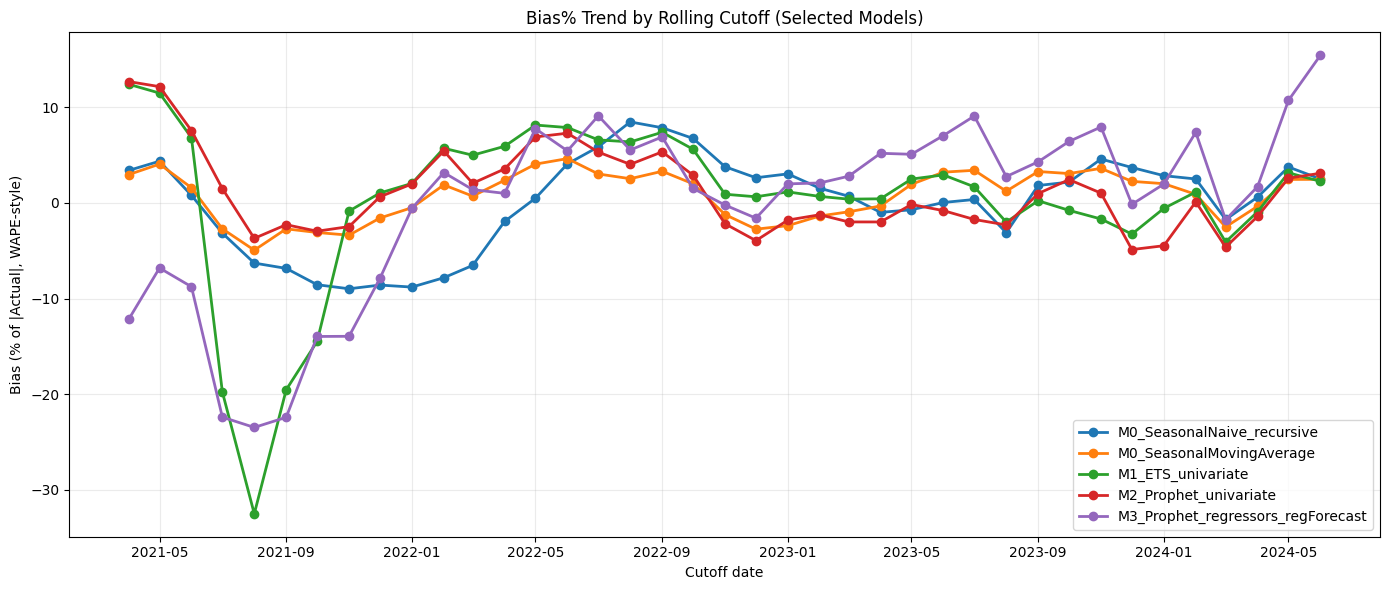

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths ----
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output"
DETAIL_CSV = os.path.join(BASE_DIR, "backtest_detail.csv")

# ---- Choose which models to plot (edit this list) ----
# NOTE: plusDrift removed
MODELS_TO_PLOT = [
    "M0_SeasonalNaive_recursive",
    "M0_SeasonalMovingAverage",
    "M1_ETS_univariate",
    "M2_Prophet_univariate",
    "M3_Prophet_regressors_regForecast",
]

# If your detail file still contains "variant" (org/cal), choose which one to plot:
VARIANT_TO_PLOT = "org"  # ignored if no 'variant' column exists

# Governance guide lines
BIAS_OK = 3.0
BIAS_WATCH = 5.0
WAPE_OK = 10.0
WAPE_WATCH = 15.0

SHOW_LEGEND = True

# -----------------------------
# Read + prep
# -----------------------------
detail = pd.read_csv(DETAIL_CSV)

# Standardize types/columns
detail["cutoff"] = pd.to_datetime(detail["cutoff"], errors="coerce")
detail["model"] = detail["model"].astype(str)

# Optional variant filtering (if the file contains it)
if "variant" in detail.columns:
    detail["variant"] = detail["variant"].astype(str)
    detail = detail[detail["variant"].str.lower() == VARIANT_TO_PLOT.lower()].copy()

# Coerce metrics
for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE", "RMSE", "MASE"]:
    if c in detail.columns:
        detail[c] = pd.to_numeric(detail[c], errors="coerce")

# ok column sometimes is 0/1 or True/False or string
if "ok" in detail.columns:
    if detail["ok"].dtype == object:
        detail["ok"] = detail["ok"].astype(str).str.lower().isin(["true", "1", "yes"])
    else:
        detail["ok"] = detail["ok"].astype(bool)
else:
    detail["ok"] = True  # fallback

# Filter to valid rows
dfp = detail[(detail["ok"] == True) & detail["cutoff"].notna()].copy()

# Enforce model list (and auto-drop plusDrift even if someone added it)
dfp = dfp[dfp["model"].isin(MODELS_TO_PLOT)].copy()

# -----------------------------
# Build pivots (cutoff x model)
# -----------------------------
def make_pivot(metric_col: str) -> pd.DataFrame:
    if metric_col not in dfp.columns:
        raise ValueError(f"Column '{metric_col}' not found in {DETAIL_CSV}")
    p = (
        dfp.pivot_table(index="cutoff", columns="model", values=metric_col, aggfunc="mean")
           .sort_index()
    )
    return p

wape_pivot = make_pivot("WAPE_pct")
bias_pivot = make_pivot("Bias_WAPE_pct")

# -----------------------------
# Plot: WAPE trend
# -----------------------------
plt.figure(figsize=(14, 6))

for m in MODELS_TO_PLOT:
    if m in wape_pivot.columns:
        plt.plot(wape_pivot.index, wape_pivot[m], marker="o", linewidth=2, label=m)

# OK/WATCH reference lines
#plt.axhline(WAPE_OK, linestyle="--", linewidth=2)
#plt.axhline(WAPE_WATCH, linestyle="--", linewidth=1)

plt.title("WAPE% Trend by Rolling Cutoff (Selected Models)")
plt.xlabel("Cutoff date")
plt.ylabel("WAPE (%)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Plot: Bias trend
# -----------------------------
plt.figure(figsize=(14, 6))

for m in MODELS_TO_PLOT:
    if m in bias_pivot.columns:
        plt.plot(bias_pivot.index, bias_pivot[m], marker="o", linewidth=2, label=m)

# Normal bias range +/-3% (OK) and optional +/-5% (Watch)
#plt.axhline(+BIAS_OK, linestyle="--", linewidth=2)
#plt.axhline(-BIAS_OK, linestyle="--", linewidth=2)
#plt.axhline(+BIAS_WATCH, linestyle="--", linewidth=1)
#plt.axhline(-BIAS_WATCH, linestyle="--", linewidth=1)

plt.title("Bias% Trend by Rolling Cutoff (Selected Models)")
plt.xlabel("Cutoff date")
plt.ylabel("Bias (% of |Actual|, WAPE-style)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()


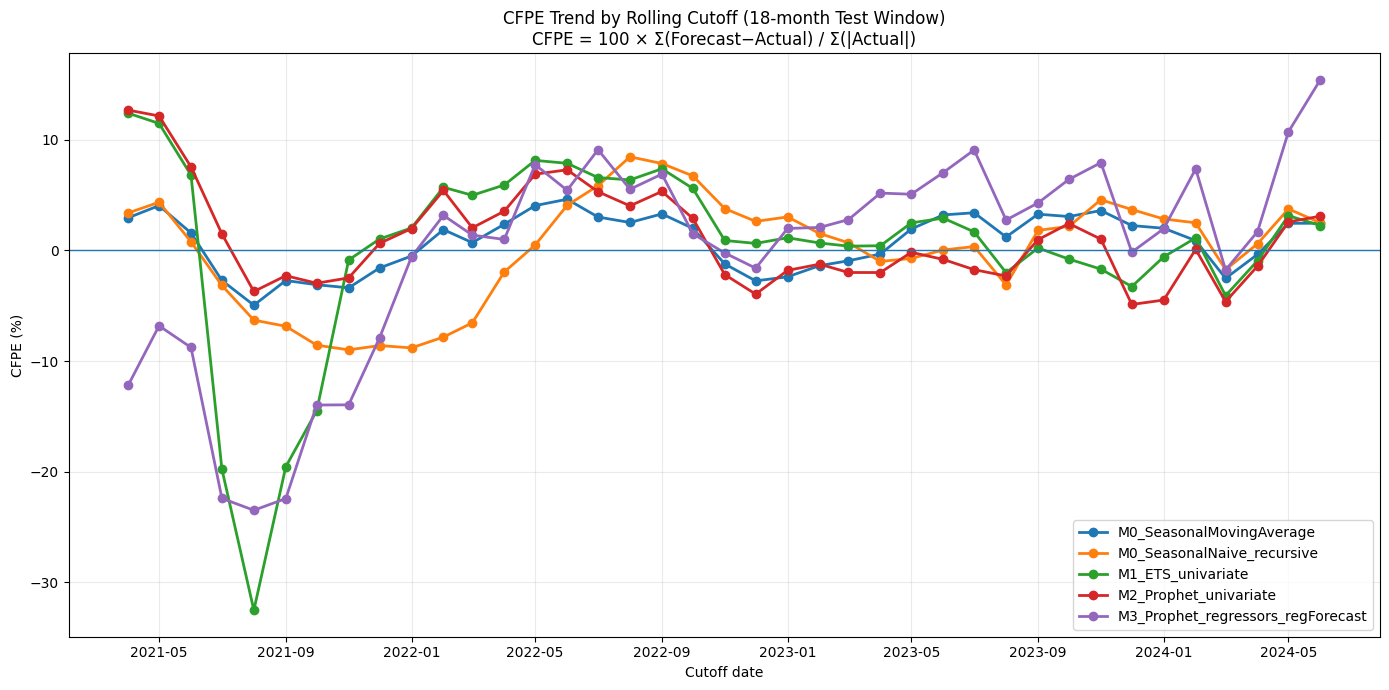


CFPE table (first 10 rows):
      cutoff                              model  test_months  total_actual  \
0 2021-04-01           M0_SeasonalMovingAverage           18   36712801.53   
1 2021-04-01         M0_SeasonalNaive_recursive           18   36712801.53   
2 2021-04-01                  M1_ETS_univariate           18   36712801.53   
3 2021-04-01              M2_Prophet_univariate           18   36712801.53   
4 2021-04-01  M3_Prophet_regressors_regForecast           18   36712801.53   
5 2021-05-01           M0_SeasonalMovingAverage           18   36348690.96   
6 2021-05-01         M0_SeasonalNaive_recursive           18   36348690.96   
7 2021-05-01                  M1_ETS_univariate           18   36348690.96   
8 2021-05-01              M2_Prophet_univariate           18   36348690.96   
9 2021-05-01  M3_Prophet_regressors_regForecast           18   36348690.96   

   total_abs_actual  total_forecast           CFE   CFPE_pct  \
0       36712801.53    3.779602e+07  1.083216e+0

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Paths
# -------------------------------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output"
MONTHLY_CSV = os.path.join(BASE_DIR, "backtest_monthly_org.csv")  # or backtest_monthly_org_cal.csv

# -------------------------------------------------
# Settings
# -------------------------------------------------
VARIANT_FILTER = None  # "org" / "cal" / None
MODELS_TO_PLOT = None  # or list of models
SHOW_LEGEND = True

# -------------------------------------------------
# Read + prep
# -------------------------------------------------
m = pd.read_csv(MONTHLY_CSV)

for col in ["cutoff", "ds"]:
    if col in m.columns:
        m[col] = pd.to_datetime(m[col], errors="coerce")

# Ensure column names exist
if "y_actual" not in m.columns:
    for alt in ["actual", "y", "ACTUAL", "TOT_PAID"]:
        if alt in m.columns:
            m = m.rename(columns={alt: "y_actual"})
            break

if "yhat" not in m.columns:
    for alt in ["forecast", "y_pred", "yhat_org", "pred"]:
        if alt in m.columns:
            m = m.rename(columns={alt: "yhat"})
            break

required = {"cutoff", "ds", "model", "y_actual", "yhat"}
missing = sorted(list(required - set(m.columns)))
if missing:
    raise ValueError(f"Missing required columns in {MONTHLY_CSV}: {missing}")

m["y_actual"] = pd.to_numeric(m["y_actual"], errors="coerce")
m["yhat"] = pd.to_numeric(m["yhat"], errors="coerce")

if VARIANT_FILTER is not None and "variant" in m.columns:
    m = m[m["variant"].astype(str).str.lower() == str(VARIANT_FILTER).lower()].copy()

m = m[np.isfinite(m["y_actual"].values) & np.isfinite(m["yhat"].values)].copy()

if MODELS_TO_PLOT is not None:
    m = m[m["model"].isin(MODELS_TO_PLOT)].copy()

# -------------------------------------------------
# Compute CFPE per cutoff+model (+variant)
# CFPE (%) = 100 * sum(forecast-actual) / sum(|actual|)
# -------------------------------------------------
group_cols = ["cutoff", "model"]
if "variant" in m.columns:
    group_cols.append("variant")

m["error"] = m["yhat"] - m["y_actual"]
m["abs_actual"] = np.abs(m["y_actual"])

agg = (
    m.groupby(group_cols, as_index=False)
     .agg(
         test_months=("ds", "nunique"),
         total_actual=("y_actual", "sum"),
         total_abs_actual=("abs_actual", "sum"),
         total_forecast=("yhat", "sum"),
         CFE=("error", "sum"),
     )
)

# CFPE
den = agg["total_abs_actual"].replace(0, np.nan)
agg["CFPE_pct"] = 100.0 * (agg["CFE"] / den)

# -------------------------------------------------
# Pivot for plotting
# -------------------------------------------------
if "variant" in agg.columns:
    agg["series_name"] = agg["model"].astype(str) + "_" + agg["variant"].astype(str)
else:
    agg["series_name"] = agg["model"].astype(str)

pivot = (
    agg.pivot_table(index="cutoff", columns="series_name", values="CFPE_pct", aggfunc="mean")
       .sort_index()
)

# optional ordering
series_order = list(pivot.columns)
if MODELS_TO_PLOT is not None:
    if "variant" in agg.columns:
        order = []
        for mm in MODELS_TO_PLOT:
            for vv in sorted(agg["variant"].dropna().unique()):
                name = f"{mm}_{vv}"
                if name in pivot.columns:
                    order.append(name)
        series_order = order if order else series_order
    else:
        series_order = [mm for mm in MODELS_TO_PLOT if mm in pivot.columns]
pivot = pivot.reindex(columns=series_order)

# -------------------------------------------------
# Plot CFPE
# -------------------------------------------------
plt.figure(figsize=(14, 7))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", linewidth=2, label=col)

plt.axhline(0, linewidth=1)  # zero net bias line
plt.title("CFPE Trend by Rolling Cutoff (18-month Test Window)\nCFPE = 100 × Σ(Forecast−Actual) / Σ(|Actual|)")
plt.xlabel("Cutoff date")
plt.ylabel("CFPE (%)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()

print("\nCFPE table (first 10 rows):")
print(
    agg.sort_values(["cutoff", "model"] + (["variant"] if "variant" in agg.columns else []))
       .head(10)
)
